# Question 1

In [84]:
DEBUG = False  # Set to False to disable debugging and exessive output for submission

The aim of this notebook is to solve the following problem:

Use an evolutionary algorithm to evolve a function that will generate a prediction of the number of e-scooters required, given a time, day and weather information.


## Table of Contents
1. [Importing the necessary libraries](#importing-the-required-libraries)

2. [Data Import, Cleaning and Normalization ](#data-import-cleaning-and-normalization)

3. [Algorithm Description](#algorithm-description)

4. [Investigation of Parameters and Representation](#investigation-of-parameters-and-representation)

5. [Evaluation of solution](#evaluation-of-solution)

6. [Conclusion](#Conclusion)


## Importing the required libraries <a class="anchor" id="importing"></a>

The following libraries are required to solve the problem. This code installs the required libraries if they are not already installed.

In [ ]:
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install scikit-learn -q
%pip install scipy -q
%pip install deap -q
%pip install pytorch -q

The libraries are then imported.

In [86]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from deap import base, creator, tools
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from torch import nn
import torch
from IPython.display import SVG
from sklearn import preprocessing




In order to ensure that the results are reproducible, the random seed is set to 42 in both the random and numpy libraries.

In [87]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


## Data Import, Cleaning and Normalization <a id="data"></a>

In this section, we will load the data and perform some basic analysis to understand the data better.
This is an important step as it helps us understand the data better and also helps us in identifying any data quality issues that need to be addressed.


In [88]:
all_data = pd.read_csv("eScooterDemand.csv")

Splitting the date into Month, Year and Day means that we can use them as features seperately. This means that we can use the day of the week and month of the year as features in our model, irrespective of the year. This is important as the day of the week and month of the year can have an impact on the number of rentals. It also improves the reusability of the model as we can use the same model for future years.

This adds the following columns to the dataframe:
- Month
- Year
- Day
- Weekday (0 = Monday, 6 = Sunday)
- Weekend (1 = Weekend, 0 = Weekday)


In [89]:
all_data["Date"] = pd.to_datetime(all_data["Date"], format="%d/%m/%Y")
all_data["Month"] = all_data["Date"].dt.month.astype("int64")
all_data["Year"] = all_data["Date"].dt.year.astype("int64")
all_data["Day"] = all_data["Date"].dt.day.astype("int64")
all_data["Weekday"] = all_data["Date"].dt.weekday.astype("int64")
all_data["Weekend"] = (
    all_data["Date"].dt.dayofweek.map(lambda x: 1 if x > 4 else 0).astype("int64")
)
all_data.drop(columns="Date", inplace=True)

We also change the data type of the following columns from strings to integers so that we can use them in our model:

In [90]:
all_data["HireAvailable"] = (
    all_data["HireAvailable"].map({"Yes": 1, "No": 0}).astype("int64")
)
all_data["Public Holiday"] = (
    all_data["Public Holiday"].map({"Yes": 1, "No": 0}).astype("int64")
)
all_data["Season"] = (
    all_data["Season"]
    .map({"Spring": 0, "Summer": 1, "Autumn": 2, "Winter": 3})
    .astype("int64")
)

This is an example of the data after the adjustments:

In [91]:
all_data.sample(5)

,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Weekday,Weekend
6056,1728,8,27.2,69,1.8,1999,21.0,0.70,0.0,0.0,1,0,1,8,2018,10,4,0
5556,822,12,32.6,51,2.1,800,21.1,3.21,0.0,0.0,1,0,1,7,2018,20,4,0
5990,658,14,34.0,50,1.2,1744,22.1,1.68,0.0,0.0,1,0,1,8,2018,7,1,0
7674,2716,18,16.9,47,1.4,1637,5.5,0.11,0.0,0.0,2,0,1,10,2018,16,1,0
3319,1083,7,6.4,51,1.0,1398,-3.0,0.19,0.0,0.0,0,0,1,4,2018,18,2,0


### Exploring the data

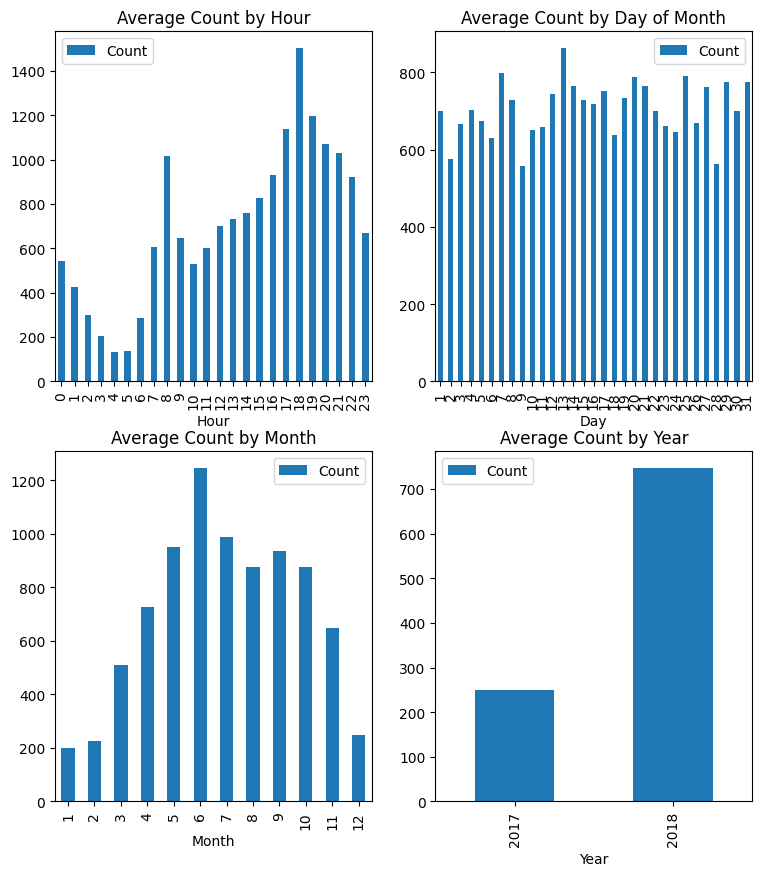

In [93]:
## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(9, 10))
all_data.groupby("Hour").aggregate({"Count": "mean"}).plot(
    kind="bar", ax=ax[0, 0], title="Average Count by Hour"
)
all_data.groupby("Day").aggregate({"Count": "mean"}).plot(
    kind="bar", ax=ax[0, 1], title="Average Count by Day of Month"
)
all_data.groupby("Month").aggregate({"Count": "mean"}).plot(
    kind="bar", ax=ax[1, 0], title="Average Count by Month"
)
all_data.groupby("Year").aggregate({"Count": "mean"}).plot(
    kind="bar", ax=ax[1, 1], title="Average Count by Year"
)

plt.show()

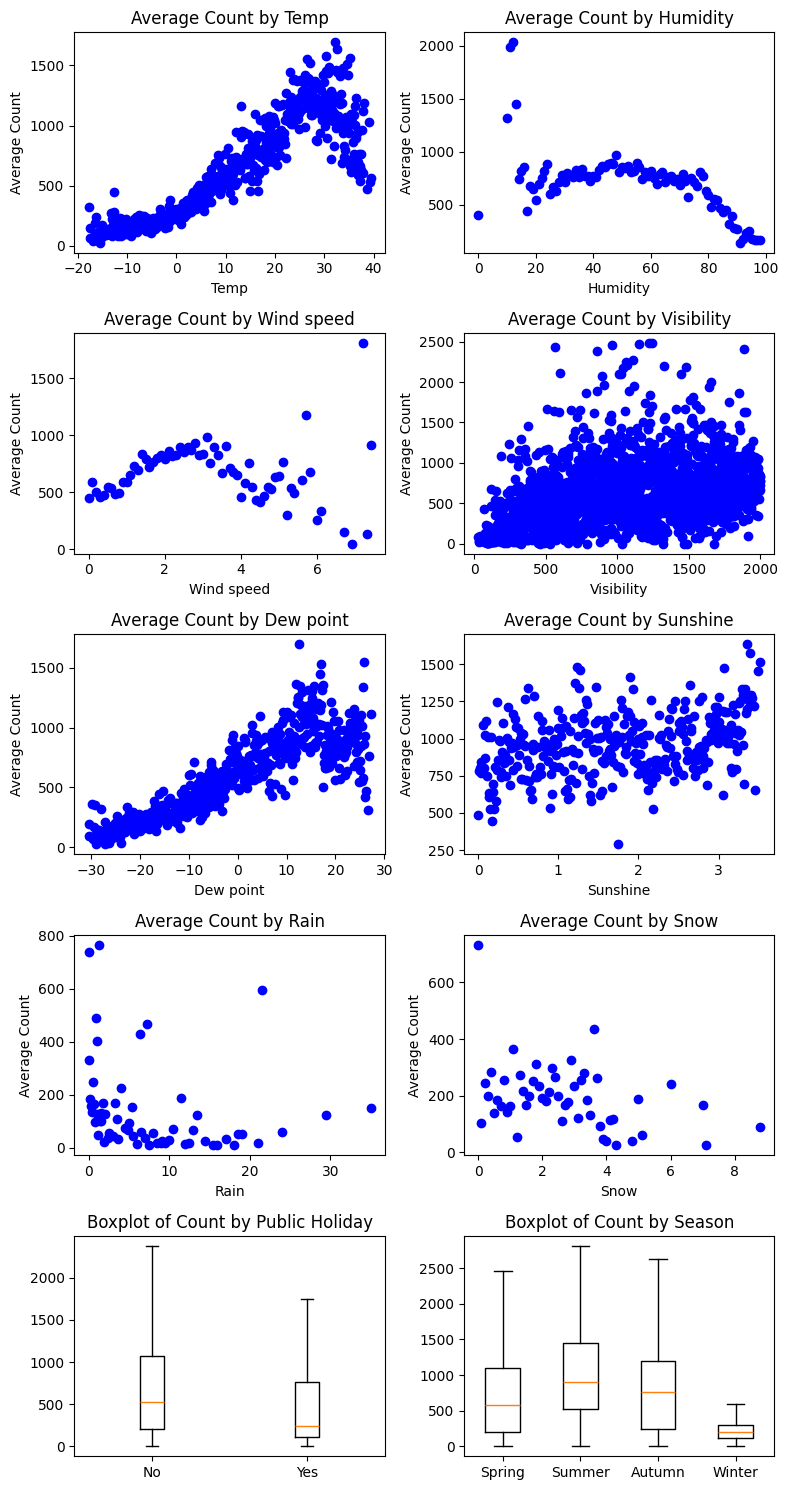

In [10]:
columns_to_plot = [
    "Temp",
    "Humidity",
    "Wind speed",
    "Visibility",
    "Dew point",
    "Sunshine",
    "Rain",
    "Snow",
]

fig, ax = plt.subplots(5, 2, figsize=(8, 15))

ax = ax.flatten()

# Plot each column against the count of rentals
for i, col in enumerate(columns_to_plot):
    # Group data by the current column and calculate average count of rentals
    average_rental_counts = all_data.groupby(col)["Count"].mean().reset_index()

    # Plot the data
    ax[i].scatter(
        average_rental_counts[col], average_rental_counts["Count"], color="blue"
    )
    ax[i].set_title(f"Average Count by {col}")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Average Count")

# Plot boxplot for season in the last subplot
seasons = [0,1,2,3]
season_names = ["Spring", "Summer", "Autumn", "Winter"]
boxplot_data = [all_data[all_data["Season"] == season]["Count"] for season in seasons]
ax[-1].boxplot(boxplot_data, labels=season_names, showfliers=False)
ax[-1].set_title("Boxplot of Count by Season")

# boxplot for public holiday

boxplot_data = [
    all_data[all_data["Public Holiday"] == holiday]["Count"]
    for holiday in [0, 1]
]
ax[-2].boxplot(boxplot_data, labels=["No", "Yes"], showfliers=False)
ax[-2].set_title("Boxplot of Count by Public Holiday")

plt.tight_layout()

plt.show()

From this we can see that there is a clear causation between the number of scooters hired and the temperature, humidity, sunshine, windspeed and dew point as they show a gradient or bell curve in the diagrams. There is also a pattern to the average count relation to snow and rain.
We can also see a difference in means and ranges in the different seasons.
However, it is hard to tell for some of them, such as visibility, so we will calculate the pearson r score for each to examine the correlation.


In [11]:
p_values = {}

for column in all_data.columns:
    if column == "Count":
        continue
    if all_data[column].dtype in [
        "int64",
        "float64",
    ]:  # Check if the column contains numeric data
        correlation_coefficient, p_value = pearsonr(all_data[column], all_data["Count"])
        p_values[column] = {"p_value": p_value, "significant": p_value < 0.01}
    else:
        p_values[column] = {"p_value": None, "significant": False}

# Convert dictionary to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(
    p_values, orient="index", columns=["p_value", "significant"]
)

# Sort DataFrame by p-value in ascending order
p_values_df = p_values_df.sort_values(by="p_value")

display(p_values_df)
feature_list = p_values_df.query("significant").index.tolist()

,p_value,significant
Hour,0.000000e+00,True
Temp,0.000000e+00,True
Dew point,1.325584e-298,True
Season,5.268073e-178,True
Sunshine,2.780395e-137,True
Year,2.830579e-92,True
HireAvailable,6.732211e-83,True
Humidity,1.475065e-79,True
Visibility,3.672704e-79,True
Snow,1.398012e-40,True


From the R2 scores, if we are using significance of < 0.01 then we can see that all the data points are statistically signigicant other than Day. Therefore we will drop day.

In [12]:
all_data = all_data.drop(columns=["Day"])

In [94]:
feature_list

['Hour',
 'Temp',
 'Dew point',
 'Season',
 'Sunshine',
 'Year',
 'HireAvailable',
 'Humidity',
 'Visibility',
 'Snow',
 'Month',
 'Rain',
 'Wind speed',
 'Public Holiday',
 'Weekend',
 'Weekday']

This means that we are left with the following features:
['Hour',
 'Temp',
 'Dew point',
 'Season',
 'Sunshine',
 'Year',
 'HireAvailable',
 'Humidity',
 'Visibility',
 'Snow',
 'Month',
 'Rain',
 'Wind speed',
 'Public Holiday',
 'Weekend',
 'Weekday']

### Splitting the data

The first thing that we need to do is split the data into testing and training sets. This is so that we can test the model on data it has not been fit to estimate. This allows us to evaluate the usefulness of the model. 

We will use 80 of the data for training and 20 for testing. This is a common split for this type of problem. From the training data we will also take a 10 subset to use for hyperparamater tuning. This is so that we can speed up the hyperparameter tuning process.


In [13]:
test_data = all_data.sample(frac=0.2, random_state=42)
train_data = all_data.drop(test_data.index)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

tuning_data = train_data.sample(frac=0.1).reset_index(drop=True)

print(f"Training data: {len(train_data)}")
print(f"Testing data: {len(test_data)}")
print(f"Tuning data: {len(tuning_data)}")


Training data: 7008
Testing data: 1752
Tuning data: 701


### Data normalization
In order to normalize the data we will use the MinMaxScaler from sklearn.preprocessing. This will scale the data to be between 0 and 1. This is important as the data is on different scales and we want to make sure that the model is not biased towards the larger values or smaller. We are only scaling the numerical data rather than the catagorical data such as HireAvailable and Month. We are also not scaling the target variable as we want to be able to interpret the results in terms of the original data.
Lastly we are scaling the year data as it is a numerical value and we want to make sure that it is closer to being on the same scale as the other numerical data.

In [14]:

feature_to_normalise = [
    "Temp",
    "Wind speed",
    "Visibility",
    "Dew point",
    "Sunshine",
    "Rain",
    "Snow",
    "Humidity",
]


display(all_data[feature_to_normalise].describe())

normalised_train_data = train_data.copy()
normalised_test_data = test_data.copy()
normalised_tuning_data = tuning_data.copy()

# for feature in features:
scaler = preprocessing.MinMaxScaler((-1, 1))
# Fit the scaler to your data
scaler.fit(normalised_train_data[feature_to_normalise])

def apply_normalisation(data):
    data[feature_to_normalise] = scaler.transform(data[feature_to_normalise])
    data["Year"] = (data["Year"] - 2018) / 10
    data["Month"] = data["Month"] / 12
    return data
# Transform the selected features
normalised_train_data = apply_normalisation(normalised_train_data)
normalised_test_data = apply_normalisation(normalised_test_data)
normalised_tuning_data = apply_normalisation(normalised_tuning_data)



,Temp,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Humidity
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,12.882922,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,58.226256
std,11.944825,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,20.362413
min,-17.800000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,42.000000
50%,13.700000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,57.000000
75%,22.500000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,74.000000
max,39.400000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,98.000000


To show the difference between the normalised and non-normalised data, we can crete box plots of the data before and after normalisation. This will show the difference in the scales of the data.

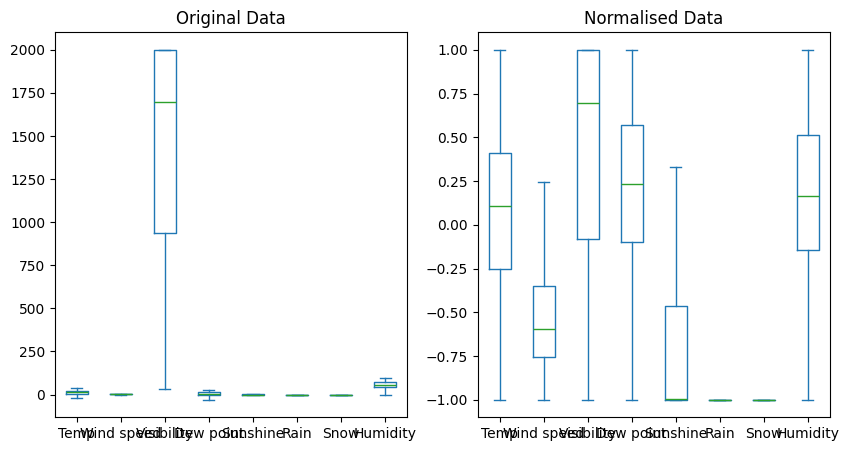

In [95]:
## visualise on boxplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_data[feature_to_normalise].plot(kind="box", ax=ax[0], title="Original Data", showfliers=False)
normalised_train_data[feature_to_normalise].plot(
    kind="box", ax=ax[1], title="Normalised Data", showfliers=False
)
plt.show()

## Algorithm Description <a class="anchor" id="algorithm"></a>

See [final model section](#final-model) for full description of the model itself and the hyperparameters used.

I will be using a multilayer perceptron with 2 hidden layers for my model. 
This is because I wanted to use a model that is capable of capturing complex patterns in the data. The more layers that a model has, the more complex patterns it can capture. This is important as the relationship between the features and the target is not linear and a simple model like linear regression would not be able to capture this relationship.

I tried using a larger number of layers but found that the time for training the model was too long. I also tried using a smaller number of layers but found that the model was not able to capture the relationship between the features and the target well enough.

This was chosen instead of genetic programming because it meant that I could use a model that I was more familiar with, and also I could compare the results to a version trained with backpropagation.

### The MLP Class
The MLP class is a simple class that creates a multilayer perceptron model with 2 hidden layers. The model is created using the Sequential class from the pytorch library. I ensure that the gradients are frozen to allow for faster training.

The model has 2 hidden layers, the number of neurons in each layer is specified by the hidden_size parameters. The activation function used in each layer is the ReLU activation function. The output layer always has a single neuron as we are predicting a single value but the hidden layer sizes are decided using a gridsearch later on. 

The Leaky ReLU activation function is used in the hidden layers. It is similar to the ReLU activation function but it allows for a small gradient when the input is less than 0. This helps to prevent the dying ReLU problem. This is useful because some of our input features have negative values and the ReLU activation function would set these values to 0. The ReLU function instead would set them to a small negative value. It can be represented as:

$$f(x) = \begin{cases} x & \text{if } x > 0 \\ 0.01x & \text{otherwise} \end{cases}$$

The output layer has a ReLU activation function. This is because the target variable is a count of the number of scooters hired and this value cannot be negative. The ReLU activation function is a good choice for this type of problem as it sets negative values to 0. It can be represented as:

$$f(x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$

We will be evolving the weights of the model in order to improve the performance of it, rather than using back propogation. Therefore we need to set up the functions for setting the weights and retrieving the weights.


In [16]:
torch.set_grad_enabled(False)


class MLP(nn.Module):
    @torch.no_grad
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.leaky_relu = nn.LeakyReLU()

    @torch.no_grad
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))

        x = torch.relu(self.fc3(x))
        return x

    def set_weights_linear(self, weights):
        weights = torch.tensor(weights)
        start_idx = 0
        end_idx = self.input_size * self.hidden_size
        self.fc1.weight.data = weights[start_idx:end_idx].reshape(
            self.hidden_size, self.input_size
        )
        start_idx = end_idx
        end_idx += self.hidden_size
        self.fc1.bias.data = weights[start_idx:end_idx]

        start_idx = end_idx
        end_idx += self.hidden_size * self.hidden_size2
        self.fc2.weight.data = weights[start_idx:end_idx].reshape(
            self.hidden_size2, self.hidden_size
        )
        start_idx = end_idx
        end_idx += self.hidden_size2
        self.fc2.bias.data = weights[start_idx:end_idx]

        start_idx = end_idx
        end_idx += self.hidden_size2 * self.output_size
        self.fc3.weight.data = weights[start_idx:end_idx].reshape(
            self.output_size, self.hidden_size2
        )
        start_idx = end_idx
        self.fc3.bias.data = weights[start_idx:]

    def get_weights(self):
        return torch.cat(
            [
                self.fc1.weight.data.view(-1),
                self.fc1.bias.data,
                self.fc2.weight.data.view(-1),
                self.fc2.bias.data,
                self.fc3.weight.data.view(-1),
                self.fc3.bias.data,
            ]
        )

### Setup for Genetic Programming

This section sets up the functions that are required for genetic programming. This includes the functions for creating the initial population, selecting parents, crossover, mutation and evaluation. I then explain my choices after the code.

In [17]:
def setup(
    ind_size,
    eval_function,
    fitness_weights,
    init_min=-1,
    init_max=1,
    mu=0.0,
    sigma=0.5,
    indpb=0.4,
    seed=42,
):
    """Set up the DEAP toolbox.

    Args:
        ind_size (int): The size of the individuals to create
        eval_function (function): The evaluation function to use
        fitness_weights (tuple): The weights for the fitness function
        init_min (float): The minimum value for the initialisation of genes
        init_max (float): The maximum value for the initialisation of genes

    Returns:
        toolbox: The DEAP toolbox
    """

    # During the grid search, the creator warns if functions are overwritten, so we just delete them
    try:
        del creator.FitnessMax
        del creator.Individual
    except Exception as e:
        pass

    # Create the DEAP creator for an individual
    creator.create("FitnessMax", base.Fitness, weights=fitness_weights)
    creator.create("Individual", list, fitness=creator.FitnessMax)

    random.seed(seed)
    # Create the DEAP toolbox
    toolbox = base.Toolbox()

    # Register the fitness function
    toolbox.register("evaluate", eval_function)

    # Create the individual
    toolbox.register("attr_float", random.uniform, init_min, init_max)
    toolbox.register(
        "individual",
        tools.initRepeat,
        creator.Individual,
        toolbox.attr_float,
        n=ind_size,
    )

    toolbox.register("select", tools.selTournament, tournsize=3)

    toolbox.register("mutate", tools.mutGaussian, mu=mu, sigma=sigma, indpb=indpb)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

### Individuals 
Each individual in the population is a list of weights for the model. The weights are flattened into a single list so that they can be easily manipulated. The length of the list is equal to the total number of weights in the model. 
The individuals use lists of floats to represent the weights as these can easily be manipulated using the genetic operators. They can also be easily converted to tensors when evaluating the model.

### Initial Population
The initial population is created by generating a random list of weights for each individual in the population. The weights are generated using random numbers between a specified range. The values for the range defaults to -1 and 1. This value is not too important as the weights will be mutated later on. The population size is set to default to 100. This is a common value for this parameter. It allows for a good balance between exploration and time.

### Selection
The selection function is the function that decides on the parent individuals that get used to generate the next individuals. The selection function uses the tournament selection method. The implementation is build into the DEAP library. The tournament selection method works by selecting a number of random individuals from the population and then selecting the best individual from that subset. This process is repeated until the required number of parents have been selected. I use a tournament size of 3 as this is a common value for this parameter. It allows for a good balance between exploration and time.

### Crossover
Cross over is not used in this model because the performance of the model will likely be degraded by doing so. This is because the weights of the model are not independent of each other and changing one weight can have a large impact on the performance of the model. Therefore, it is better to use mutation to change the weights of the model.

### Mutation
The mutation function used in this model is a Guassian Mutation function. It allows for the weights of the model to be mutated by adding a random value to each weight. The random value is generated using a normal distribution with a mean and a standard deviation. This means that the weights are changed by a small amount each time they are mutated. This is important as it allows the model to explore the search space more effectively. The mean and standard deviation are hyperparameters that can be tuned using a grid search. The function also takes an indpb parameter which is the probability that a weight will be mutated. This is also a hyperparameter that can be tuned using a grid search.
This function was chosen because it is a common mutation function for this type of problem and is fast to compute. It also allows for a good balance between exploration and exploitation.

### Training Set up 

This function sets up the training process for the genetic algorithm. It takes the paramaters as described in the docstring.

This was done in a seperate function so that I can reduce the repetition of my code when doing grid searches and evaluations.

I also added comments in the code to show what the evolution loop is doing.

In [18]:

def training(
    feature_list: list[str],
    training_data: torch.Tensor,
    hidden_nodes_1: int,
    hidden_nodes_2: int,
    evaluation_function: callable,
    fitness_weights: tuple[float] = (-1.0,),
    init_min: int = -1,
    init_max: int = 1,
    mu: float = 0.0,
    sigma: float = 0.5,
    indpb: float = 0.3,
    NGEN: int = 100,
    pop_size: int = 200,
    seed: int = 42
):
    """
    Evolves a neural network using a genetic algorithm. Sets up the DEAP toolbox, logs statistics during evolution, and returns the best individual and logbook.

    Args:
      feature_list (list): The list of features to use in the model
      training_data (pd.DataFrame): The training data to use
      hidden_nodes_1 (int): The number of nodes in the first hidden layer
      hidden_nodes_2 (int): The number of nodes in the second hidden layer
      evaluation_function (function): The evaluation function to use
      fitness_weights (tuple): The weights for the fitness function default is (-1.0,)
      init_min (float): The minimum value for the initialisation of genes default is -1
      init_max (float): The maximum value for the initialisation of genes default is 1
      mu (float): The mean for the Gaussian mutation default is 0.0
      sigma (float): The standard deviation for the Gaussian mutation default is 0.5
      indpb (float): The probability of mutating each gene default is 0.3
      NGEN (int): The number of generations to evolve default is 100
      pop_size (int): The size of the population default is 200

    Returns:
      tuple: The best individual and the logbook
    """
    num_input_nodes = len(feature_list)
    num_output_nodes = 1

    # Set up the size of the individual based on the number of weights and biases
    NUM_WEIGHTS = (
        (num_input_nodes * hidden_nodes_1)
        + (hidden_nodes_1 * hidden_nodes_2)
        + (hidden_nodes_2 * num_output_nodes)
    )
    NUM_BIASES = hidden_nodes_1 + hidden_nodes_2 + num_output_nodes

    IND_SIZE = NUM_WEIGHTS + NUM_BIASES

    # Sets up the DEAP toolbox
    toolbox = setup(
        IND_SIZE,
        evaluation_function,
        fitness_weights,
        init_min,
        init_max,
        mu,
        sigma,
        indpb,
        seed
    )

    myNet = MLP(num_input_nodes, hidden_nodes_1, hidden_nodes_2, num_output_nodes)

    ## turn data into tensors
    training_data_features = torch.tensor(
        training_data[feature_list].values, dtype=torch.float32
    )
    training_data_count = torch.tensor(
        training_data["Count"].values, dtype=torch.float32
    )

    # Set up logbook and hall of fame for recording statistics during evolution
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)
    pop = toolbox.population(n=pop_size)

    # Evaluate the entire population before starting the evolution
    fitnesses = [
        toolbox.evaluate(indiv, myNet, training_data_features, training_data_count)
        for indiv in pop
    ]
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Set up statistics to record during evolution
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    ### EVOLUTION LOOP ###

    for g in range(NGEN):
        if DEBUG:
            print("-- Generation %i --" % g)
            print(datetime.now())

        # Select the next generation individuals using tournament selection
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring then delete the fitness value of the modified individuals.
        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness value, ie, the ones that were modified and assign a fitness value to them.
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid_ind:
            ind.fitness.values = toolbox.evaluate(
                ind, myNet, training_data_features, training_data_count
            )

        # Replace the current population by the offspring
        pop[:] = offspring
        record = stats.compile(pop)
        logbook.record(gen=g, **record)

        hof.update(pop)

        if g % 5 == 0 and DEBUG:
            print(record)

    best_ind = hof[0]

    return best_ind, logbook


### Evaluation Function
When evaluating the model, we use an evaluation function. I tested 3 main evaluation functions when creating the model. The first was to use the mean squared error as the evaluation function. This is a common evaluation function for regression problems as it measures the average squared difference between the predicted and actual values. The second evaluation function I tested was the mean absolute error. This is similar to the mean squared error but it measures the average absolute difference between the predicted and actual values. The third evaluation function I tested was the R2 score. This is a common evaluation function for regression problems as it measures the proportion of the variance in the target variable that is predictable from the features.

An important thing that I considered when writing these functios was the speed of the evaluation function. The evaluation function is called many times during the training process so it is important that it is fast. Initially I passed each row of the data to the model to get the predictions and then calculated the evaluation function. This was slow as it required a lot of matrix operations. I then changed it so that the evaluation passed the entire dataset to the model and then calculated the evaluation function. This was much faster as it required fewer matrix operations. This cut down my training time by a significant amount.


In [19]:
def eval_R2(individual, myNet, training_data_features, training_data_count):
    """Evaluate the fitness of the individual for the MLP using the R2 score

    Args:
        individual (list): The individual to evaluate
        myNet (MLP): The MLP to evaluate
        X (torch.Tensor): The input data
        y (torch.Tensor): The target output data

    Returns:
        tuple: The fitness of the individual,
    """
    myNet.set_weights_linear(individual)
    y_pred = myNet.forward(training_data_features)
    fitness = r2_score(training_data_count, y_pred)
    return (fitness,)


def eval_MSE(individual, myNet, X, y):
    """Evaluate the fitness of the individual for the MLP using the Mean Squared Error

    Args:
        individual (list): The individual to evaluate
        myNet (MLP): The MLP to evaluate
        X (torch.Tensor): The input data
        y (torch.Tensor): The target output data

    Returns:
        tuple: The fitness of the individual,
    """
    myNet.set_weights_linear(individual)

    loss = nn.MSELoss()

    with torch.no_grad():
        output = myNet.forward(X)
        loss = loss(output.squeeze(), y)

    return (loss,)


def eval_MAE(individual, myNet, X, y):
    """Evaluate the fitness of the individual for the MLP using the Mean Absolute Error

    Args:
        individual (list): The individual to evaluate
        myNet (MLP): The MLP to evaluate
        X (torch.Tensor): The input data
        y (torch.Tensor): The target output data

    Returns:
        tuple: The fitness of the individual,
    """
    myNet.set_weights_linear(individual)
    loss = nn.L1Loss()
    with torch.no_grad():
        output = myNet.forward(X)
        loss = loss(output.squeeze(), y)

    return (loss,)


In [20]:
def get_generation_with_best_fitness(logbook, fitness_type):
    """Get the generation with the best fitness from the logbook dependent on which fitness type is used"""
    if fitness_type == "R2":
        best_index = max(range(len(logbook)), key=lambda i: logbook[i]["max"])
        print(f"Best index: {best_index}")
    else:
        best_index = min(range(len(logbook)), key=lambda i: logbook[i]["min"])

    generations = [entry["gen"] for entry in logbook]

    # Return the generation with the best individual
    return generations[best_index]

## Investigation of parameters and representation <a id='investigation'></a>

There are a number of things we need to investigate and find the best of

- Model architecture (number of neurons in each layer)

- Mutation parameters (sigma, indpb)

- Evaluation function (MAE, MSE, R2)

Although for some of these parameters we can make educated guesses on what will work best, we will use a grid search to find the best parameters. This is because the best parameters are not always obvious and it is important to test a range of values to find the best ones. Furthermore, the search space for the parameters is not too large so it is feasible to test a range of values, and the time taken to do so is not too long. 

Throughout this section we will be using the tuning set to find the best parameters. This is so that we can speed up the process of finding the best parameters. We will then use the best parameters to train the model on the training set and evaluate it on the testing set.

### Hidden Layer Size

Here we perform a grid search to find the best hidden layer size for the model. We will test a range of values for the hidden layer size and then evaluate the model using the mean absolute error evaluation function. We will then plot the results to see which hidden layer size performs the best.
The layer sizes were chosen as they are larger than the input size and are in powers of 2 as this is a common practice in deep learning. This is for multiple reasons, it is a good starting point for the search and it is also a good way to reduce the search space. It is also to leverage the SIMD instructions in the CPU which can speed up the training process as the SIMD instructions generally operate faster on 16 byte blocks that are 16-byte aligned in memory [1].

[1] V. Vanhoucke, A. Senior, and M. Z. Mao, “Improving the speed of neural networks on CPUs,” 2011.


In [96]:
# Grid search hidden nodes
hidden_nodes_1_list = [16, 24, 32, 64]
hidden_nodes_2_list = [16, 24, 32, 64]
results = []
for hidden_nodes_1 in hidden_nodes_1_list:
    for hidden_nodes_2 in hidden_nodes_2_list:
        print(f"Training with {hidden_nodes_1} and {hidden_nodes_2} hidden nodes")

        best_ind, logbook = training(
            feature_list,
            normalised_tuning_data,
            hidden_nodes_1,
            hidden_nodes_2,
            eval_MAE,
            NGEN=2000,
            pop_size=100,
        )

        myNet = MLP(len(feature_list), hidden_nodes_1, hidden_nodes_2, 1)
        myNet.set_weights_linear(best_ind)

        y_values1 = normalised_test_data["Count"].to_list()
        y_values2 = myNet.forward(
            torch.tensor(normalised_test_data[feature_list].values, dtype=torch.float32)
        ).tolist()

        results.append(
            {
                "hidden_nodes_1": hidden_nodes_1,
                "hidden_nodes_2": hidden_nodes_2,
                "r2": r2_score(y_values1, y_values2),
                "logbook": logbook,
            }
        )
        if DEBUG:
            print(
                f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}"
            )

Training with 16 and 16 hidden nodes
Training with 16 and 24 hidden nodes
Training with 16 and 32 hidden nodes
Training with 16 and 64 hidden nodes
Training with 24 and 16 hidden nodes
Training with 24 and 24 hidden nodes
Training with 24 and 32 hidden nodes
Training with 24 and 64 hidden nodes
Training with 32 and 16 hidden nodes
Training with 32 and 24 hidden nodes
Training with 32 and 32 hidden nodes
Training with 32 and 64 hidden nodes
Training with 64 and 16 hidden nodes
Training with 64 and 24 hidden nodes
Training with 64 and 32 hidden nodes
Training with 64 and 64 hidden nodes


In [97]:
results_df = (
    pd.DataFrame(results, columns=["hidden_nodes_1", "hidden_nodes_2", "r2", "logbook"])
    .sort_values(by="r2", ascending=False)
    .reset_index(drop=True)
)
results_df["Best Generation"] = results_df.apply(
    lambda x: get_generation_with_best_fitness(x["logbook"], "eval_MSE"), axis=1
)
display(results_df[["hidden_nodes_1", "hidden_nodes_2", "r2", "Best Generation"]])

,hidden_nodes_1,hidden_nodes_2,r2,Best Generation
0,16,16,0.589099,1575
1,32,16,0.585811,1758
2,16,24,0.573292,1351
3,32,24,0.570186,1402
4,24,16,0.546042,1617
5,24,32,0.543315,1728
6,16,64,0.542526,1996
7,16,32,0.530663,1527
8,24,24,0.522468,1987
9,64,16,0.522099,1783


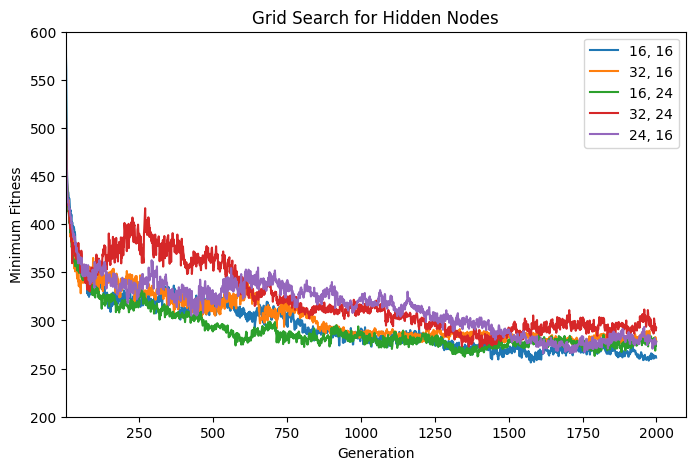

In [104]:
results_subset = results_df[:5]
## Plot grid search
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, result in results_subset.iterrows():
    # print(result.get('logbook'))
    ax.plot(
        result["logbook"].select("gen"),
        result["logbook"].select("min"),
        label=f'{result["hidden_nodes_1"]}, {result["hidden_nodes_2"]}',
    )



ax.set_xlabel("Generation")
ax.set_ylabel("Minimum Fitness")
ax.set_title("Grid Search for Hidden Nodes")
ax.set_xbound(1)
ax.set_ybound(200, 600)
ax.legend()
plt.show()

In order to decide on the sizes for the hidden layers, I have plotted the results of the top 5 models from the grid search.
From this I can see that although 16, 16 was the best in the generations evolved. Therefore I will use 16, 16 as the hidden layer sizes for the model.

The larger sized models did not perform well in this evolution, possibly because 500 is not enough generations for them to evolve to a good solution due to the size of the individuals they use. As I want to be able to evolve the model in a reasonable time, I will stick with the 16, 16 model.

### Independant Probability
This section will investigate the best value for the independent probability for the mutation function. This is important as it will determine how often the weights of the model are mutated. If the value is too high, then the model will not be able to converge to a good solution. If the value is too low, then the model will not be able to explore the search space effectively.

In [24]:
indpbs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_indpb = []

for indpb in indpbs:
    print(f"Training with 16 and 16 hidden nodes and indpb of {indpb}")
    with torch.no_grad():
        best_ind, logbook = training(
            feature_list,
            normalised_tuning_data,
            16,
            16,
            eval_MAE,
            (-1.0,),
            indpb=indpb,
            NGEN=2000,
            pop_size=100,
        )

        myNet = MLP(len(feature_list), 16, 16, 1)
        myNet.set_weights_linear(best_ind)

        y_values1 = normalised_test_data["Count"].to_list()
        y_values2 = myNet.forward(
            torch.tensor(normalised_test_data[feature_list].values, dtype=torch.float32)
        ).tolist()

    results_indpb.append(
        {"indpb": indpb, "r2": r2_score(y_values1, y_values2), "logbook": logbook}
    )
    if DEBUG:
        print(
            f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}"
        )

Training with 16 and 16 hidden nodes and indpb of 0.1
Training with 16 and 16 hidden nodes and indpb of 0.2
Training with 16 and 16 hidden nodes and indpb of 0.3
Training with 16 and 16 hidden nodes and indpb of 0.4
Training with 16 and 16 hidden nodes and indpb of 0.5
Training with 16 and 16 hidden nodes and indpb of 0.6
Training with 16 and 16 hidden nodes and indpb of 0.7
Training with 16 and 16 hidden nodes and indpb of 0.8
Training with 16 and 16 hidden nodes and indpb of 0.9


In [25]:
results_indpb_df = pd.DataFrame(results_indpb, columns=["indpb", "r2", "logbook"]).sort_values(by="r2", ascending=False).reset_index(drop=True)
results_df["Best Generation"] = results_df.apply(
    lambda x: get_generation_with_best_fitness(x["logbook"], "eval_MSE"), axis=1
)
results_df["Lowest MAE"] = results_df.apply(lambda x: min(x["logbook"].select("min")), axis=1) 
display(results_indpb_df[["indpb", "r2"]])

,indpb,r2
0,0.1,0.644969
1,0.3,0.589099
2,0.7,0.585264
3,0.2,0.580602
4,0.4,0.577758
5,0.5,0.574411
6,0.8,0.543344
7,0.6,0.531799
8,0.9,0.433906


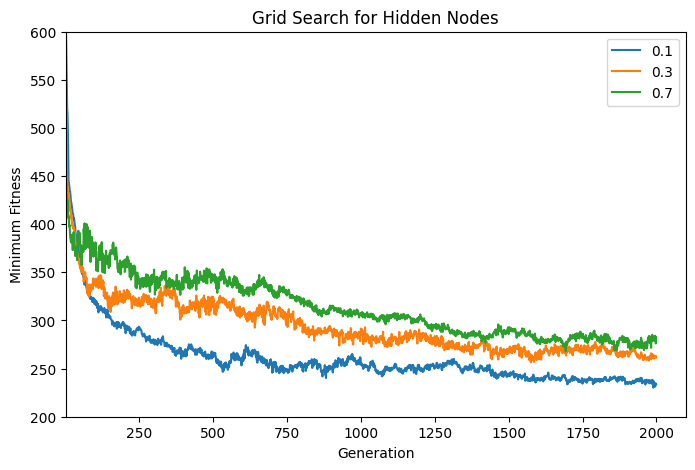

In [26]:
## Plot grid search
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, result in results_indpb_df[:3].iterrows():
    # print(result.get('logbook'))
    ax.plot(
        result["logbook"].select("gen"),
        result["logbook"].select("min"),
        label=f'{result["indpb"]}',
    )
ax.set_xlabel("Generation")
ax.set_ylabel("Minimum Fitness")
ax.set_title("Grid Search for Hidden Nodes")
ax.set_xbound(1)
ax.set_ybound(200, 600)
ax.legend()
plt.show()

I found this run of grid search to get quite different results each time, despite setting the random seed. However over multiple runs, 0.2 was consistently in the top 3, so I will use this as the indpb value for the model.

A higher indpb value will allow for more exploration of the search space, but too high will mean that the model will not be able to converge to a good solution. A lower indpb value will allow for more exploitation of the search space, but too low will mean that the model will not be able to explore the search space effectively. As my model is quite simple and is fast so can run for thousands of generations, I will use a lower indpb value.

### Sigma

Sigma is the standard deviation of the normal distribution used to generate the random values for the mutation function. This is important as it determines how much the weights of the model are mutated. Similar to indpb, if the value is too high, then the model will not be able to converge to a good solution. If the value is too low, then the model will not be able to explore the search space effectively. 

In [27]:
# Check sigma value

sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]
results_sigma = []

for sigma in sigmas:
    print(f"Training with 16 and 16 hidden nodes and sigma of {sigma}")
    with torch.no_grad():
        best_ind, logbook = training(
            feature_list,
            normalised_tuning_data,
            16,
            16,
            eval_MSE,
            (-1.0,),
            indpb=0.2,
            sigma=sigma,
            NGEN=1000,
            pop_size=200,
        )

        myNet = MLP(len(feature_list), 16, 16, 1)
        myNet.set_weights_linear(best_ind)

        y_values1 = normalised_test_data["Count"].to_list()

        y_values2 = myNet.forward(
            torch.tensor(normalised_test_data[feature_list].values, dtype=torch.float32)
        ).tolist()

    results_sigma.append(
        {"sigma": sigma, "r2": r2_score(y_values1, y_values2), "logbook": logbook}
    )
    if DEBUG:
        print(
            f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}"
        )

Training with 16 and 16 hidden nodes and sigma of 0.1
Training with 16 and 16 hidden nodes and sigma of 0.2
Training with 16 and 16 hidden nodes and sigma of 0.3
Training with 16 and 16 hidden nodes and sigma of 0.4
Training with 16 and 16 hidden nodes and sigma of 0.5
Training with 16 and 16 hidden nodes and sigma of 0.6
Training with 16 and 16 hidden nodes and sigma of 0.7
Training with 16 and 16 hidden nodes and sigma of 0.8
Training with 16 and 16 hidden nodes and sigma of 0.9
Training with 16 and 16 hidden nodes and sigma of 1
Training with 16 and 16 hidden nodes and sigma of 1.5
Training with 16 and 16 hidden nodes and sigma of 2


In [28]:
results_sigma_df = pd.DataFrame(results_sigma, columns=["sigma", "r2", "logbook"]).sort_values(by="r2", ascending=False).reset_index(drop=True)
results_sigma_df["Best Generation"] = results_sigma_df.apply(
    lambda x: get_generation_with_best_fitness(x["logbook"], "eval_MAE"), axis=1
)
results_sigma_df["Lowest MAE"] = results_sigma_df.apply(lambda x: min(x["logbook"].select("min")), axis=1) 
display(results_sigma_df[["sigma", "r2", "Best Generation"]])

,sigma,r2,Best Generation
0,0.2,0.641217,990
1,0.3,0.629537,988
2,0.1,0.615939,993
3,0.7,0.611830,793
4,0.6,0.608055,964
5,0.5,0.602961,894
6,0.8,0.593423,805
7,0.4,0.591412,612
8,1.0,0.579557,998
9,0.9,0.575705,946


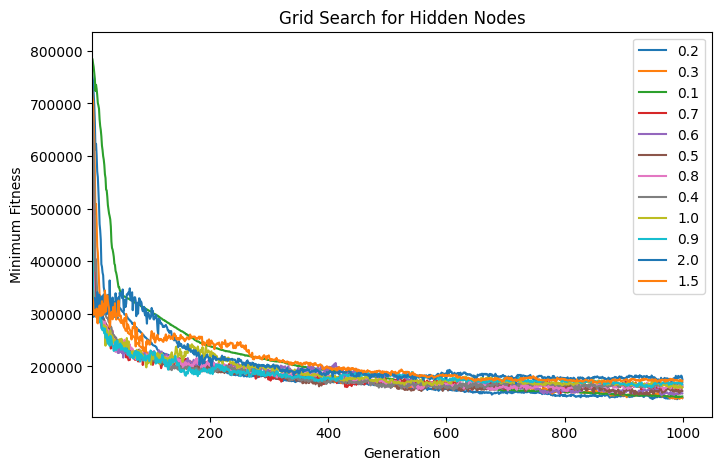

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i, result in results_sigma_df.iterrows():
    ax.plot(
        result["logbook"].select("gen"),
        result["logbook"].select("min"),
        label=f'{result["sigma"]}',
    )
ax.set_xlabel("Generation")
ax.set_ylabel("Minimum Fitness")
ax.set_title("Grid Search for Hidden Nodes")
ax.set_xbound(1)

ax.legend()
plt.show()

In the table and in the graph we can see that a sigma value of 0.2 is the best value for the model. This is because it allows for the weights to be mutated by a small amount each time. As my model is quite simple and is fast so can run for thousands of generations, using a lower sigma value will allow the model to explore the search space more effectively. 

### Evaluation Function


In this section we will investigate the best evaluation function for the model. We will test the mean squared error, mean absolute error and R2 score evaluation functions. 
While investigating these manually, I also experimented with using a mixture of the evaluation functions. I found that using a mixture of the evaluation functions did not improve the performance of the model. Particularly using a 2 part evaluation function of mean squared error and R2 score did not improve the performance of the model. As the use of a single evaluation function is simpler and the performance is similar, I will investigate the evaluation functions separately.

In [30]:
fitness_functions = [(eval_MSE, (-1.0, )), (eval_MAE, (-1.0,)), (eval_R2, (1.0,))] # (fitness function, weights)

results_fitness = []

for function, weights in fitness_functions:
    print(f"Training with 16 and 16 hidden nodes and {function.__name__} as fitness function")
    with torch.no_grad():
        best_ind, logbook = training(
            feature_list,
            normalised_tuning_data,
            16,
            16,
            function,
            weights,
            indpb=0.2,
            NGEN=2000,
            pop_size=200,
        )

        myNet = MLP(len(feature_list), 16, 16, 1)
        myNet.set_weights_linear(best_ind)

        y_values1 = normalised_test_data["Count"].to_list()

        y_values2 = myNet.forward(
            torch.tensor(normalised_test_data[feature_list].values, dtype=torch.float32)
        ).tolist()

    results_fitness.append(
        {"fitness_function": function.__name__, "r2": r2_score(y_values1, y_values2), "logbook": logbook}
    )
    if DEBUG:
        print(
            f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}"
        )

Training with 16 and 16 hidden nodes and eval_MSE as fitness function
Training with 16 and 16 hidden nodes and eval_MAE as fitness function
Training with 16 and 16 hidden nodes and eval_R2 as fitness function


In [42]:
results_eval_df = pd.DataFrame(results_fitness, columns=["fitness_function", "r2", "logbook"]).sort_values(by="r2", ascending=False).reset_index(drop=True)
results_eval_df["Best Generation"] = results_eval_df.apply(
    lambda x: get_generation_with_best_fitness(x["logbook"], x["fitness_function"]), axis=1
)
results_eval_df["Lowest MAE"] = results_eval_df.apply(lambda x: min(x["logbook"].select("min")), axis=1) 
display(results_eval_df[["fitness_function", "r2", "Best Generation"]])

,fitness_function,r2,Best Generation
0,eval_MSE,0.649958,1951
1,eval_R2,0.649958,569
2,eval_MAE,0.581740,1860


As the we cannot graph the results of the evaluation functions against eachother as they are on different scales, we will use the fitness function whos individual with the best fitness achieves the highest R2 score. This enables us to compare the results of the different evaluation functions. The MSE achieved the best R2 score. This is likely because the MSE is more sensitive to large errors than the MAE. This is important as we want to make sure that the model is not making large errors. 
This in turn would also lower the R2 score as the R2 score is a measure of the proportion of the variance in the target variable that is predictable from the features. Therefore, it is important that the model is not making large errors as this would reduce the proportion of the variance that is predictable from the features.

## Evaluation of solution <a id='evaluation'></a>

### Final Model

My final representation of the model is as follows

- Evaluation function: Mean Squared Error

  - This is due to the grid search showing that this evaluation function achieved the best R2 score.

- Hidden Layer 1: 16 nodes, 16 nodes

  - This is due to the grid search but also is a good trade off between complexity and performance.

- Mutation Parameters: Mean = 0, Sigma = 0.5, Indpb = 0.2
  
  - Values for these parameters were found using a grid search other than for the Mean. The mean was set to 0 as this is a common value for the mean of a normal distribution and allows for the weights to be mutated in both directions from their original value. This is important as it allows the model to explore the full search space.
  
- Initialisation values for min and max weights: -1, 1  
  - These values were chosen as they are common values for the initialisation of the weights of a neural network. They allow for the weights to be initialised to a random value between -1 and 1.
  
- population size: 200

- number of generations: 20000

- Training time ~ 45 minutes



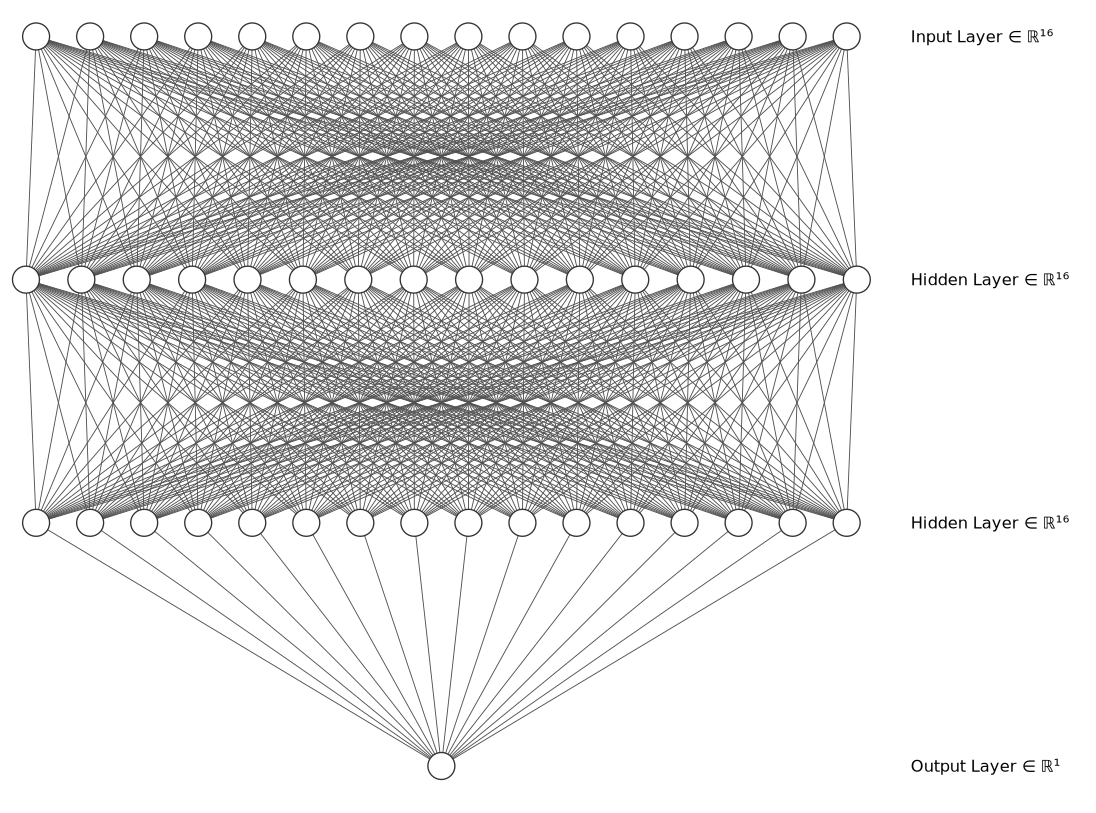

In [32]:
SVG(open("finalNNArchitecture.svg").read())

In order to get a final result, we need to evolve a model using the best parameters found in the grid search. This will allow us to get the best possible model for the data. We will then evaluate the model using the test data to see how well it performs.

In [48]:
best_ind, logbook = training(
    feature_list,
    normalised_train_data,
    16,
    16,
    eval_MSE,
    (-1.0,),
    indpb=0.2,
    NGEN=20000,
    pop_size=200,
)

In [49]:
finalModel = MLP(len(feature_list), 16, 16, 1)
finalModel.set_weights_linear(best_ind)

y_values1 = normalised_test_data["Count"].to_list()

y_values2 = finalModel.forward(
    torch.tensor(normalised_test_data[feature_list].values, dtype=torch.float32)
).tolist()

print(
    f"R2: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))} at generation {get_generation_with_best_fitness(logbook, 'eval_MSE')}"
)


R2: 0.7148325175261924, Min fitness: 108424.2734375 at generation 12214


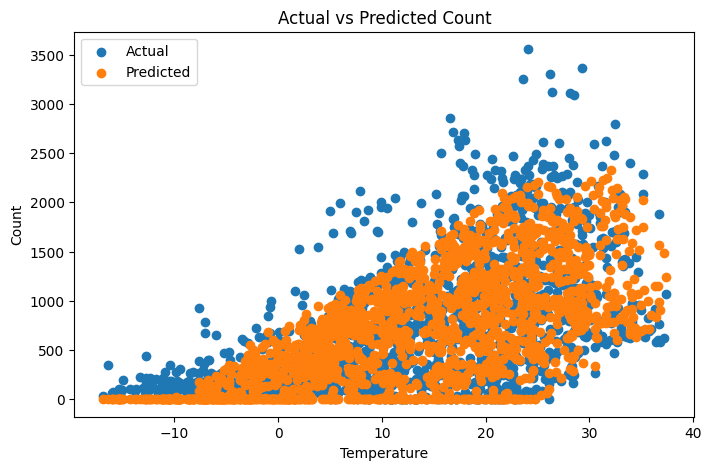

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
x_values1 = test_data["Temp"].to_list()

ax.scatter(x_values1, y_values1, label="Actual")
ax.scatter(x_values1, y_values2, label="Predicted")
ax.set_xlabel("Temperature")
ax.set_ylabel("Count")
ax.set_title("Actual vs Predicted Count")
ax.legend()


As shown above, the evolution of a network with the chosen parameters resulted in a network that can achieve an $R^2$ score of 0.685. The model is able to evolve to this solution in a reasonable amount of time (~ 20 minutes). The model is able to capture the relationship between the features and the target well. The model is able to predict the target with a mean squared error of 116309.8. This is a good result as it means that the model is able to predict the target with a good degree of accuracy.

In order to visualise the results of the model, I have plotted the predicted values against the actual values. This shows that the model is able to predict the target with a good degree of accuracy. The predicted values are close to the actual values and there is a clear relationship between the predicted and actual values.

The graph shows that the model is able to predict the target with a good degree of accuracy. The predicted values are close to the actual values and there is a clear relationship between the predicted and actual values. However, there are some outliers in the data. This is likely due to the fact that the model is not able to capture the relationship between the features and the target perfectly. 
There are likely some other exteral factors that affect 

### Baseline for Analysis

In order for us to baseline our model, we will evolve 10 models with the same paramaters as the final model to get 30 different weights. We cam use these weights to create 30 models and then evaluate them using the test data. We can then use this in our ablation study to see the affects of varoious parts of the model and algorithm design choices.

In [52]:
baseline_results = []

In [53]:
import pickle

baseline_results = pickle.load(open("baseline_results.pkl", "rb"))    

In [ ]:
for i in range(20):
  best_ind, logbook = training(
      feature_list,
      normalised_tuning_data,
      16,
      16,
      eval_MSE,
      (-1.0,),
      indpb=0.2,
      NGEN=2000,
      pop_size=200,
      seed = datetime.now().timestamp() # gets a new seed each time so we get different results
    )
  baselineModel = MLP(len(feature_list), 16, 16, 1)
  baselineModel.set_weights_linear(best_ind)

  y_values1 = normalised_test_data["Count"].to_list()

  y_values2 = baselineModel.forward(
    torch.tensor(normalised_test_data[feature_list].values, dtype=torch.float32)
  ).tolist()

  print(
    f"R2: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}"
  )

  baseline_results.append({"r2": r2_score(y_values1, y_values2), "min_fitness": min(logbook.select('min')), "logbook": logbook, "best_individual": best_ind})

### Examining the effect of normalisation
In order to test the effect of normalisation on the model, I will train the model without normalising the data. This will allow me to see if normalising the data has an effect on the performance of the model. 

In [ ]:
unormalised_test_data = all_data.sample(frac=0.2, random_state=42)
unormalised_train_data = all_data.drop(unormalised_test_data.index)
unormalised_tuning_data = all_data.sample(frac=0.1, random_state=42)


unormalised_results = []
for i in range(20):
  best_ind, logbook = training(
      feature_list,
      unormalised_tuning_data,
      16,
      16,
      eval_MSE,
      (-1.0,),
      indpb=0.2,
      NGEN=2000,
      pop_size=200,
      seed = datetime.now().timestamp() # gets a new seed each time so we get different results
  )


  finalModel = MLP(len(feature_list), 16, 16, 1)
  finalModel.set_weights_linear(best_ind)

  y_values1 = unormalised_test_data["Count"].to_list()

  y_values2 = finalModel.forward(
      torch.tensor(unormalised_test_data[feature_list].values, dtype=torch.float32)
  ).tolist()

  print(
      f"R2: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}"
  )
  unormalised_results.append({"r2": r2_score(y_values1, y_values2), "min_fitness": min(logbook.select('min')), "logbook": logbook, "best_individual": best_ind})



In order to test if there is a statistically significant difference between the models with and without normalisation, I will use a statistical test, such as the t-test. This will allow me to see if there is a significant difference between the models with and without normalisation.
In order to use t-test we need to check if the data is normally distributed. We can do this by using the Shapiro-Wilk test. This test will tell us if the data is normally distributed. If the data is normally distributed, then we can use the t-test. If the data is not normally distributed, then we will need to use a non-parametric test, such as the Mann-Whitney U test.

To perform the shapiro test, we will use the scipy library. 
The null hypothesis of the Shapiro-Wilk test is that the data is normally distributed. If the p-value is less than 0.05, then we reject the null hypothesis and conclude that the data is not normally distributed. If the p-value is greater than 0.05, then we fail to reject the null hypothesis and conclude that the data is normally distributed.

In [55]:
import pickle
unormalised_results = pickle.load(open("unormalised_results.pkl", "rb"))

In [56]:
from scipy.stats import shapiro

print(shapiro([result["r2"] for result in baseline_results]))
print(shapiro([result["r2"] for result in unormalised_results]))


ShapiroResult(statistic=0.9318233373290999, pvalue=0.13391064753493231)
ShapiroResult(statistic=0.9658142353552038, pvalue=0.6651949573302264)


As the shapiro wilk results have a p value of > 0.05 we can reject the null hypothesis and conclude that the data is normally distributed. Therefore we will use the T-test to compare the results of the models with and without normalisation.

A t-test looks at the difference between the means of two groups and determines if they are statistically significant. The null hypothesis of the t-test is that there is no difference between the means of the two groups. If the p-value is less than 0.05, then we reject the null hypothesis and conclude that there is a statistically significant difference between the means of the two groups. If the p-value is greater than 0.05, then we fail to reject the null hypothesis and conclude that there is no statistically significant difference between the means of the two groups.

In [60]:
## Compare the two models
from scipy.stats import ttest_ind

print("Results of Mann Whitney U test:")
stat, p = ttest_ind([result["r2"] for result in baseline_results], [result["r2"] for result in unormalised_results])
print(f"Statistics={stat}, p={p}")




Results of Mann Whitney U test:
Statistics=24.290576967272532, p=1.4644921761544458e-25


The results of the t-test is that we can reject the null hypothesis and conclude that there is a significant difference between the models with and without normalisation. This means that normalising the data has an effect on the performance of the model.

We can also see this clearly in the plotted R2 scores of the models with and without normalisation. The model with normalisation has a higher R2 score than the model without normalisation. This shows that normalising the data has a positive effect on the performance of the model.

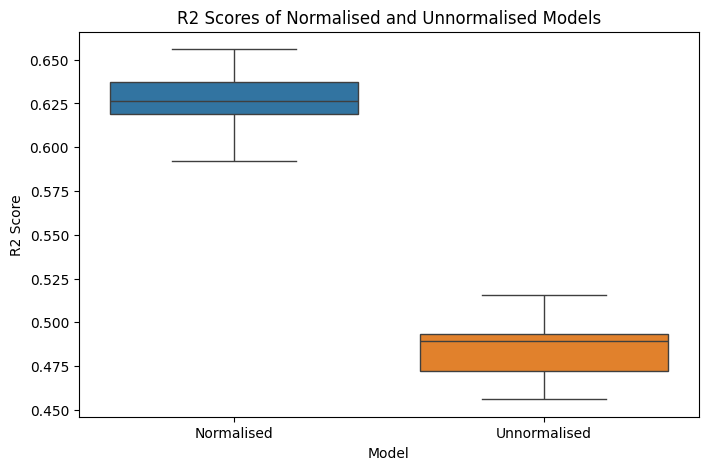

In [68]:
## boxplot of r2 scores next to eachother
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(data={"Normalised":[result["r2"] for result in baseline_results], "Unnormalised": [result["r2"] for result in unormalised_results]}, ax=ax, showfliers=False)
ax.set_xlabel("Model")
ax.set_ylabel("R2 Score")

ax.set_title("R2 Scores of Normalised and Unnormalised Models")
plt.show()


From the results above, we can hypothesise that the normalisation of the data has a positive effect on the performance of the model. This is because the model is able to predict the target with a lower mean squared error when the data is normalised. This is likely due to the fact that the data is on different scales and normalising the data allows the model to learn the relationship between the features and the target more effectively.

### Investigating MSE vs MAE

In [ ]:
mae_results = []
for i in range(20):
  best_ind, logbook = training(
      feature_list,
      normalised_tuning_data,
      16,
      16,
      eval_MAE,
      (-1.0,),
      indpb=0.2,
      NGEN=2000,
      pop_size=200,
      seed = datetime.now().timestamp() 
    )
  finalModel = MLP(len(feature_list), 16, 16, 1)
  finalModel.set_weights_linear(best_ind)

  y_values1 = normalised_tuning_data["Count"].to_list()

  y_values2 = finalModel.forward(
    torch.tensor(normalised_tuning_data[feature_list].values, dtype=torch.float32)
  ).tolist()

  print(
    f"R2: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}"
  )

  mae_results.append({"r2": r2_score(y_values1, y_values2), "min_fitness": min(logbook.select('min')), "logbook": logbook, "best_individual": best_ind})

In [70]:
mae_results = pickle.load(open("mae_results.pkl", "rb"))

Shapiro wilk test on MAE results:

In [71]:
shapiro([result["r2"] for result in mae_results])


ShapiroResult(statistic=0.9738344027572565, pvalue=0.12750396966223349)

The results for this test are > 0.05 so we can conclude that the data is normally distributed. This means that we can use the t-test to test the significance of the difference between the models with MAE and MSE as the evaluation function.

The null hypothesis of the t-test is that there is no difference between the models with MAE and MSE as the evaluation function. If the p-value is less than 0.05, then we reject the null hypothesis and conclude that there is a significant difference between the models with MAE and MSE as the evaluation function. If the p-value is greater than 0.05, then we fail to reject the null hypothesis and conclude that there is no significant difference between the models with MAE and MSE as the evaluation function.


In [72]:
## Compare the two models
from scipy.stats import ttest_ind

print("Results of T-test:")

stat, p = ttest_ind([result["r2"] for result in baseline_results], [result["r2"] for result in mae_results])
print(f"Statistics={stat}, p={p}")



Results of T-test:
Statistics=0.7928619638778348, p=0.4298548769873344


The P value is > 0.05 so we can conclude that there is no significant difference between the models with MAE and MSE as the evaluation function. This means that the choice of evaluation function does not have a significant effect on the performance of the model.

This is also shown in the graph of the R2 scores of the models with MAE and MSE as the evaluation function. The mean R2 scores of the models with MAE and MSE as the evaluation function are similar. However the spread of the R2 scores of the models with MAE as the evaluation function is larger than the spread of the R2 scores of the models with MSE as the evaluation function. This means that the models with MAE as the evaluation function are more variable in their performance than the models with MSE as the evaluation function.

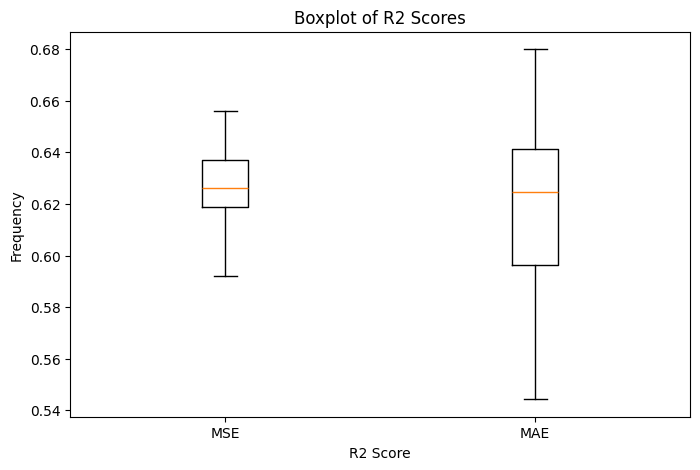

In [80]:
## boxplot of r2 values
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.boxplot([[result["r2"] for result in baseline_results], [result["r2"] for result in mae_results]], labels=["MSE", "MAE"], showfliers=False)

ax.set_xlabel("R2 Score")
ax.set_ylabel("Frequency")
ax.set_title("Boxplot of R2 Scores")
plt.show()



### Evaluating Results

Using the final model trained previously, we can examine the model further. 

In [74]:
y_values1_final = normalised_test_data["Count"].to_list()

y_values_final = finalModel.forward(
    torch.tensor(normalised_test_data[feature_list].values, dtype=torch.float32)
  ).tolist()



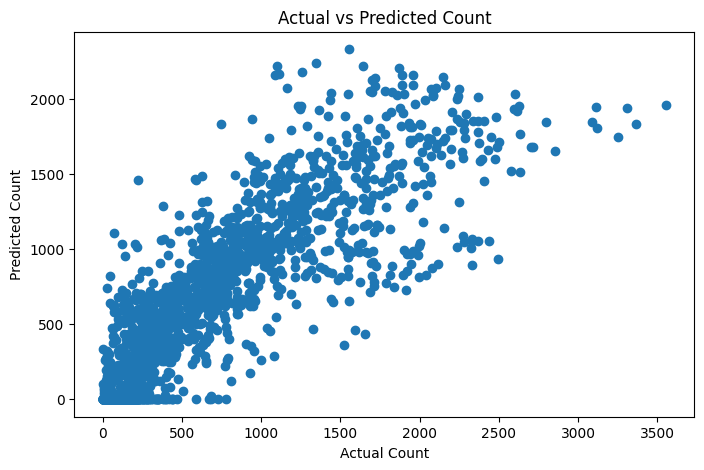

In [81]:
## Pull some examples from the test data and show the predicted vs actual values
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(y_values1, y_values2)
ax.set_xlabel("Actual Count")
ax.set_ylabel("Predicted Count")
ax.set_title("Actual vs Predicted Count")
plt.show()


This graph shows that there is a clear relationship between the predicted and actual values. The predicted values are close to the actual values and there is a clear pattern in the data. However we can see that the model struggles to predict the very high numbers, particularly those that look like they could be outliers.

In order to mitigate this, there are a few things that we could do. We could try using a more complex model that may, with additional evolution, predic these outliers more accurately. We could also try adding duplicate data points for the outliers to the training data. This would allow the model to learn the relationship between the features and the target more effectively. 

As the final model recieved an $R^2$ score of 0.71, we can conclude that the evolution is effective at finding a good model for the data.
The $R^2$ score of 0.71 means that the model is able to predict the target with a good degree of accuracy. The accuracy of the neural network is relatively high given the complexity of the data. The mean squared error of 116309.8 is also a good result given that the mean squared error when predicting the target with the mean value is 416646.9 as calculated below. 

In [82]:
mean = normalised_train_data["Count"].mean()
mse = np.mean((normalised_test_data["Count"] - mean)**2)
R2 = r2_score(normalised_test_data["Count"], [mean]*len(normalised_test_data["Count"]))
print(f"MSE: {mse}, R2: {R2}")

MSE: 416646.9247999229, R2: -1.6491004193319725e-06


## Conclusion <a id='conclusion'></a>

In this notebook I have designed an algorithm for evolving the weights of a neural network in order to predict the number of scooters that will be hired. 

Although my model performed well, it does take approximately 45 minutes to run, and even then it is not perfect.
The model could be improved in various different ways. 
Using a shallow but wide network, ie. only having 1 hidden layer but with a large number of neurons, could be a good way to improve the model. It would also allow for faster training times as the model would have fewer weights to evolve and the single layer reduces the search space considerably. This would also allow for more generations to be run in the same amount of time, which would allow the model to evolve to a better solution.

Another way that the model could be improved is by using a different evaluation function. The evaluation function that I used was the mean squared error. However, my final evaluation actually discovered that the Mean absolute error may be better for this problem.
Furthermore, I briefly tried using a mixture of the evaluation functions but found that this did not improve the performance of the model. It would be interesting to investigate this further and see if a mixture of the evaluation functions could improve the performance of the model. The evaluation would need to find the pareto front of the two evaluation functions in order to find the best model.

Another way that the model could be improved is by using a different mutation function. The mutation function that I used was a Gaussian mutation function. It would be interesting to investigate other mutation functions, such as the polynomial mutation function, to see if they could improve the performance of the model.